# Examples of working with the CHLA-Z dataset

```{important}
This notebook requires zarr version 3+!
```

In [ ]:
# if working in Colab run this code
pip install zarr

In [1]:
# Check that zarr version is 3+
import xarray as xr, zarr
print("xarray:", xr.__version__)
print("zarr:", zarr.__version__)

xarray: 2025.12.0
zarr: 3.1.5


### Open the dataset

This is a multi-terrabyte data set of daily global chlorophyll depth profiles in the ocean. 

In [3]:
import xarray as xr
zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})
ds

<xarray.Dataset> Size: 2TB
Dimensions:                    (time: 560, lat: 4320, lon: 8640, z: 20)
Coordinates:
  * time                       (time) datetime64[ns] 4kB 2024-03-05 ... 2025-...
  * lat                        (lat) float32 17kB 89.98 89.94 ... -89.94 -89.98
  * lon                        (lon) float32 35kB -180.0 -179.9 ... 179.9 180.0
  * z                          (z) float32 80B 5.0 15.0 25.0 ... 185.0 195.0
    z_start                    (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
    z_end                      (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
Data variables:
    CHLA_int_0_200             (time, lat, lon) float32 84GB dask.array<chunksize=(1, 480, 480), meta=np.ndarray>
    CHLA_peak_depth            (time, lat, lon) float32 84GB dask.array<chunksize=(1, 480, 480), meta=np.ndarray>
    CHLA_peak                  (time, lat, lon) float32 84GB dask.array<chunksize=(1, 480, 480), meta=np.ndarray>
    CHLA                       (time, z, lat, lon) float32 2TB dask.array<chunksize=(1, 1, 480, 480), meta=np.ndarray>
    CHLA_depth_center_of_mass  (time, lat, lon) float32 84GB dask.array<chunksize=(1, 480, 480), meta=np.ndarray>
    z_thickness                (time, z) float32 45kB dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                   CF-1.10 ACDD-1.3
    title:                         CHLA-Z: Global gridded chlorophyll-a verti...
    summary:                       CHLA-Z is a global gridded dataset providi...
    product_name:                  CHLA-Z
    product_version:               v1
    product_format:                Zarr v3
    ...                            ...
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    vertical_coordinate:           z
    vertical_resolution:           10 m bins (centers)
    z_units:                       m
    variables:                     CHLA (chlorophyll-a concentration on depth...

## Plot depth where peak chlorophyll occurs

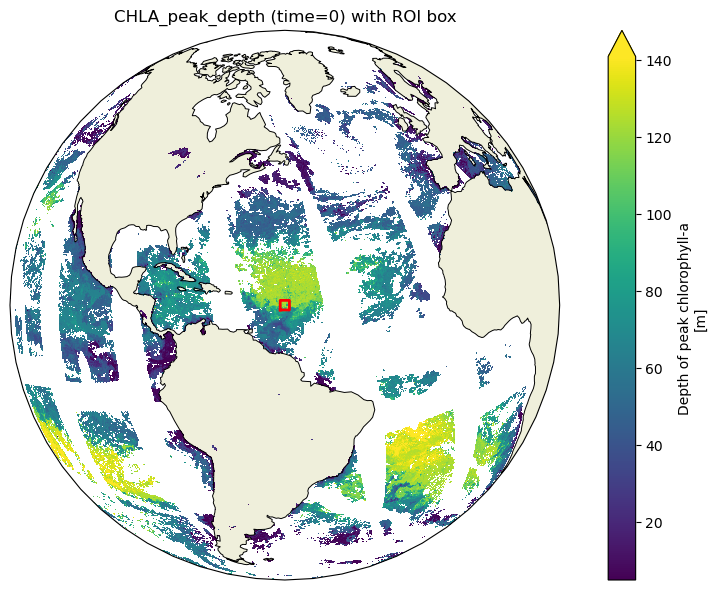

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr

zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})

# --- small ROI for time series ---
lat_small = (17, 15)
lon_small = (-55, -53)

# rectangle bounds (ensure min/max ordering)
lat_min, lat_max = sorted(lat_small)
lon_min, lon_max = sorted(lon_small)

# A "bigger area" map slice to plot (adjust padding as you like)
pad_lat = 12
pad_lon = 20
map_da = ds["CHLA_peak_depth"].isel(time=0).sel(
    lat=slice(lat_max + pad_lat, lat_min - pad_lat),
    lon=slice(lon_min - pad_lon, lon_max + pad_lon),
)
map_da = ds["CHLA_peak_depth"].isel(time=0).coarsen(lat=4, lon=4, boundary="trim").mean()

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(
    projection=ccrs.Orthographic(
        central_longitude=(lon_min + lon_max) / 2,
        central_latitude=(lat_min + lat_max) / 2,
    )
)

ax.set_global()
ax.add_feature(cfeature.LAND, linewidth=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.7)

# plot data (lon/lat grid -> PlateCarree)
map_da.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True, add_colorbar=True)

# ROI box in red
xs = [lon_min, lon_max, lon_max, lon_min, lon_min]
ys = [lat_min, lat_min, lat_max, lat_max, lat_min]
ax.plot(xs, ys, transform=ccrs.PlateCarree(), linewidth=2, color="red")

ax.set_title("CHLA_peak_depth (time=0) with ROI box")
plt.tight_layout()
plt.show()

## Plot time series of CHLA at 50m at a point in red box

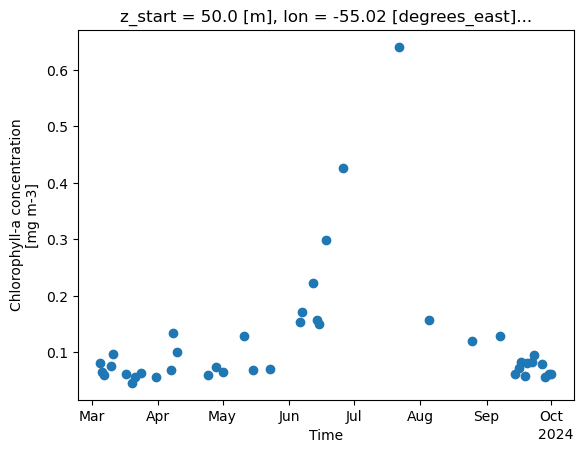

In [16]:
import xarray as xr

zarr_url = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_url, consolidated=False, 
          storage_options={"token": "anon"})

# Example: time series at a point (nearest grid cell)
pt = ds["CHLA"].sel(lon=-55, lat=17, method="nearest")
pt = pt.isel(z=5) # surface
pt.sel(time=slice("2024-03-01", "2024-10-01")).plot(
    marker="o",
    linestyle="None"
)

## Time series of monthly means of depth of peak CHLA in red box

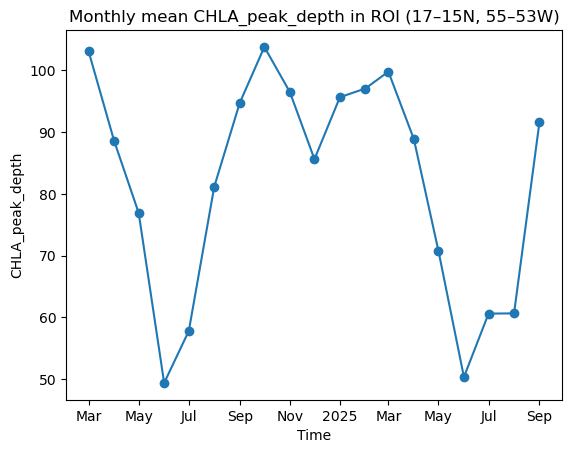

In [2]:
import xarray as xr
import matplotlib.pyplot as plt

zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})

da = ds["CHLA_peak_depth"]

# small region of interest
roi = da.sel(lat=slice(17, 15), lon=slice(-55, -53))

# monthly mean within ROI:
# 1) mean over space (lat/lon) for each timestep
# 2) resample to month starts and mean over time within each month
ts = roi.mean(("lat", "lon")).resample(time="MS").mean("time").compute()

# Plot
ts.plot(marker="o")
plt.title("Monthly mean CHLA_peak_depth in ROI (17–15N, 55–53W)")
plt.ylabel("CHLA_peak_depth")
plt.show()

In [ ]:
import xarray as xr

url = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305_v2.nc"
ds = xr.open_dataset(url, engine="h5netcdf", 
          storage_options={"token": "anon"})

# Plot surface CHLA for that day
ds["CHLA"].isel(time=0, z=0).plot()

## Kuroshio Extension Front

20-45 N, 130-180 E This is the region and the front is about in the middle E-W

32–37°N, 141–160°E